In [2]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [182]:
a = 0.03
b = 0.0002
c = 0.06
d = 0.0001

nu = 1 #制御変数の次元
nx = 2 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([10,10])
Q_f = casadi.diag([10,10])
R = casadi.diag([1])

# 予測ホライズン等
K = 20

# 制約条件
x_lb = [0,0]
x_ub = [np.inf,np.inf]
u_lb = [0]
u_ub = [10]

total = nx*(K+1) + nu*K

# 目標値
y_ref = 200
x_ref = casadi.DM([c/d,y_ref])
u_ref = casadi.DM([c/d*(b*y_ref-a)])

In [183]:
def make_F():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    y = states[1]
    u = ctrls[0]

    x_next = (1+a)*x - b*x*y + u
    y_next = (1-c)*y + d*x*y

    states_next = casadi.vertcat(x_next,y_next)

    F = casadi.Function("F",[states,ctrls],[states_next],['x','u'],['x_next'])
    return F

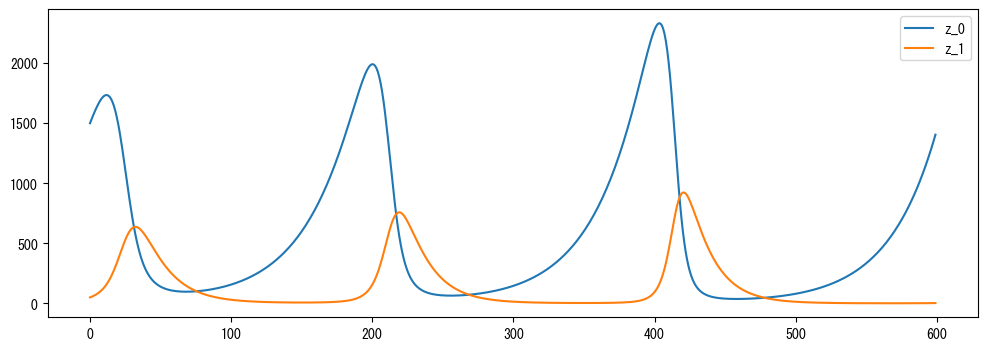

In [184]:
t_span = [0,600]
t_eval = np.arange(*t_span)

x_init = casadi.DM([1500,50]) # 初期値

F = make_F()

X = [x_init]
x_current = x_init
for t in t_eval:
    x_current = F(x=x_current,u=0)["x_next"]
    X.append(x_current)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)

plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"z_{k}")
plt.legend()

plt.savefig("images/chap4_mpc_no_control.png")
plt.show()

In [185]:
def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [186]:
def make_nlp():
    F = make_F()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])
        eq = X[k+1] - F(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':10,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [187]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [188]:
S = make_nlp()

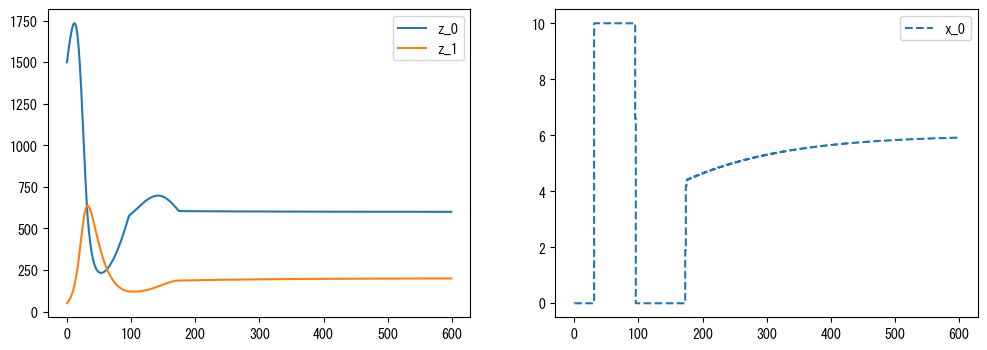

In [190]:
t_span = [0,600]
t_eval = np.arange(*t_span,1)

x_init = casadi.DM([1500,50]) # 初期値
x0 = casadi.DM.zeros(total)

F = make_F()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = F(x=x_current,u=u_opt)["x_next"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"z_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"x_{k}")
plt.legend()

plt.savefig("images/chap4_mpc.png")
plt.show()

KeyboardInterrupt: 

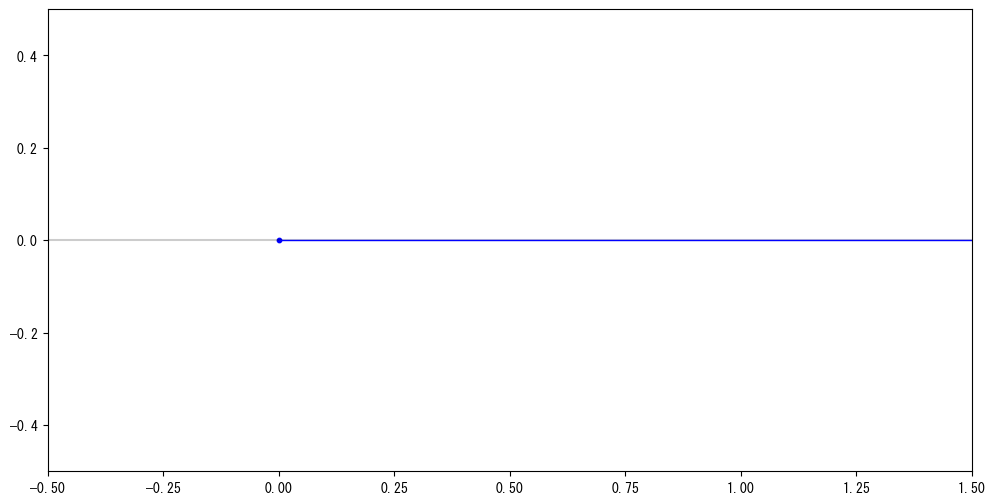

In [153]:
# fig = plt.figure(figsize=(12,6))
# ax = fig.add_subplot(111)
# frames = np.arange(0,t_eval.size)
# fps = 5

# def update_figure(i):
#     x_lim_min = -0.5
#     x_lim_max = 1.5
#     y_lim_min = -0.5
#     y_lim_max = 0.5
#     u_scale = 2

#     ax.cla()
#     ax.set_xlim(x_lim_min, x_lim_max)
#     ax.set_ylim(y_lim_min, y_lim_max)
#     ax.set_aspect("equal")

#     z,_ = X[i]
#     u, = U[i]

#     points = np.array([
#         [0,z],
#         [0,0]
#     ])

#     M = 13
#     lim = 0.1
#     springs = np.array([
#         (np.arange(0,M+1)*z/M).tolist(),
#         [0]*3+[lim,-lim]*((M-5)//2)+[0]*3
#     ])

#     ax.hlines(0,x_lim_min,x_lim_max,colors="black",alpha=0.2)
#     ax.scatter(*points,color="blue",s=10)
#     ax.plot(*springs, color='blue', lw=1)
#     ax.arrow(z,0,u/u_scale,0,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)

#     circle = patches.Circle(xy=(z,0), radius=0.01,color="blue")
#     ax.add_patch(circle)

# ani = FuncAnimation(fig, update_figure, frames=frames)
# ani.save("images/chap4_damped_oscillation.gif",writer="pillow",fps=fps)

In [17]:
# import os
# import shutil
# import glob
# import natsort
# import cv2
# shutil.rmtree("./tmp",ignore_errors=True)
# os.mkdir("./tmp")
# for i in np.linspace(0,8,6):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(3,2,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# cv2.imwrite("images/chap4_damped_oscillation_anim.png",paths)
# shutil.rmtree("./tmp",ignore_errors=True)